<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/RejectionSampling_par.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import json
import multiprocessing as mp

In [2]:
# from google.colab import files
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My\ Drive

In [3]:
class MVSampler():
    def __init__(self, reference, inference, target_cols):
        """
        reference : pd.DataFrame. 모집단으로 사용될 set.(test를 넣으면 됨)
        inference : pd.DataFrame. 배경집단으로 사용된 inference set
        target_cols : array-like. 해당 column들에 대해서만 확률 계산
        """
        self._pdf = {}
        self._cnt = np.zeros(reference.shape[0])
        self.reference = reference.copy()
        del reference
        self.inference = inference.copy()
        del inference
        self.target_cols = target_cols

        bins = int(1+3.322*np.log10(self.inference.shape[0]))
        for col in self.target_cols:
            p, bin_edge = np.histogram(self.inference[col].values,
                                       bins=np.min([bins, len(self.inference[col].unique())]),
                                       density=True)
            self._pdf[col] = (p, bin_edge)

        for col in self.target_cols:
            bin_edge = self._pdf[col][1]
            b = (bin_edge[1:] + bin_edge[:-1])/2
            lcond = self.reference[col].values>=b.min()
            rcond = self.reference[col].values<=b.max()
            self._cnt += (lcond*rcond*1)

    def build(self, row_min = -1, outlier = 0):
        """
        row_min : int. sampling에 사용될 reference의 최소 row 갯수
        outlier : int. ref/inf 의 target_col 분포를 비교할 때, 고려하지 않을 column의 갯수
        모든 target_col이 ref/inf 분포가 겹치지 않을 수 있기 때문에 일정 row 갯수가 확보될 때 까지 증가
        """
        if row_min  < 0:
            row_min = int(self.inference.shape[0] * 0.1)

        nsize = len(np.where(self._cnt>=len(self.target_cols)-outlier)[0])
        while (nsize <= row_min) and (outlier <= len(self.target_cols)):
            outlier += 1
            nsize = len(np.where(self._cnt>=len(self.target_cols)-outlier)[0])
        self._outlier = outlier

        self.log_likelihood = np.zeros(self.reference.shape[0])
        for i in range(self.reference.shape[0]):
            row_vector = self.reference.iloc[i, :]
            if self._cnt[i]>=len(self.target_cols)-outlier:
                p = np.array([self.interp_pdf(self._pdf[col], row_vector[col]) for col in self.target_cols])
                self.log_likelihood[i] = np.sum(np.log10(p[np.where(p!=0)[0]]))
                # np.power(10, np.sum(np.log10(p[np.where(p!=0)[0]])))

    @staticmethod
    def interp_pdf(pdf, x):
        p, bin_edge = pdf
        b = (bin_edge[1:] + bin_edge[:-1])/2
        if x<=b.min() or x>=b.max():
            return 0
        f = interp1d(b, p, kind="linear")
        y = f(x)
        return y

    def sample(self, n=-1, seed=None, return_index=False):
        """
        n : int. sample의 크기
        return_index : bool. True일 경우 sample의 index를 array로 return, False일 경우 sample을 pd.DataFrame으로 return. 기본은 False
        return : pd.DataFrame / array-like
        """
        n = n if n>0 else self.inference.shape[0]//10
        prob = np.power(10, self.log_likelihood)
        prob /= np.sum(prob)
        rng = np.random.default_rng(seed)
        idx = rng.choice(np.arange(0, self.reference.shape[0]), replace=True, p=prob, size=n)
        if return_index:
            return idx
        return self.reference.iloc[idx, :]

In [4]:
def dist(slope, intercept, x, y):
    return abs(slope*x-y+intercept)/np.sqrt(slope**2+1)
def linear(x, a, b):
    return a*x+b
def chi2(slope, intercept, x, y):
    dobs = dist(slope, intercept, x, y)**2
    return np.sum(dobs)/ 2 / (len(x)-2)


class PerformanceEstimator():
    def __init__(self, drift, drift_smp, metric_smp):
        self.drift = drift
        self.drift_smp = drift_smp
        self.metric_smp = metric_smp

    def estimate(self, n = 5):
        drift_list = self.drift_smp.keys()
        metric_list = self.metric_smp.keys()
        if len(self.drift[list(self.drift.keys())[0]])<n:
            return self.metric_smp

        metric_est = {}
        for key, m in self.metric_smp.items():
            metric_est[key] = self.correction(metric= m, drift =self.drift, drift_smp = self.drift_smp)
        return metric_est

    @staticmethod
    def nlinearfit(x, y, th = 2):
        x = np.array(x) if isinstance(x, list) else x
        y = np.array(y) if isinstance(y, list) else y
        m = (y.max() - y.min()) / (x.min() - x.max())
        i = y.mean() - m * x.mean()
        d, c2 = dist(m, i, x, y), chi2(m, i, x, y)
        cnt = 0

        while c2>th and m>0 and cnt<len(x)-4:
            xn, yn = x[np.argsort(d)[:len(x)-cnt]], y[np.argsort(d)[:len(x)-cnt]]
            popt, _ = curve_fit(linear, xn, yn)
            m, i = popt[0], popt[1]
            c2 = chi2(m, i, xn, yn)
            cnt += 1
        c2 = chi2(m, i, x, y)
        return m, i, c2

    @staticmethod
    def correction(metric, drift, drift_smp):
        metric_cor = 0
        denominator = 0

        for k in drift_smp.keys():
            d, d_smp =  drift[k], drift_smp[k]
            dbar = d[-1] - np.min(d)
            dbar_smp = d_smp - np.min(d_smp)
            r1, beta, chi2 = PerformanceEstimator.nlinearfit(dbar_smp, metric, 2)
            metric_cor += (r1 * dbar + beta) / chi2
            denominator +=  (1/chi2)

        return metric_cor/denominator

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
def accuracy(args):
    model, X, y = args[0], args[1], args[2]
    return accuracy_score(model.predict(X), y)*100

def f1(args):
    model, X, y = args[0], args[1], args[2]
    return f1_score(model.predict(X), y) *100

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def D3(args):
    reference, inference, model = args[0], args[1], args[2]
    y1 = np.zeros(reference.shape[0]).reshape(-1, 1)
    y2 = np.ones(inference.shape[0]).reshape(-1, 1)
    X = np.vstack((reference, inference))
    y = np.vstack((y1, y2))
    lr = LogisticRegression(solver="liblinear", random_state=0, max_iter=5000).fit(X, y.ravel())
    return roc_auc_score(y, lr.predict_proba(X)[:, 1])

from scipy.stats import ks_2samp, entropy
def uncertainty(args):
    reference, inference, model = args[0], args[1], args[2]
    entropy_ref = entropy(model.predict_proba(reference), axis = -1)
    entropy_inf = entropy(model.predict_proba(inference), axis = -1)
    d, p = ks_2samp(entropy_ref, entropy_inf)
    return d

from scipy.linalg import sqrtm
def FID(reference, inference, model):
    act_ref, act_inf = [], []

    for i in range(reference.shape[0]):
        refr, infr = reference[i, :], inference[i, :]
        vmin, vmax = min(refr.min(), infr.min()), max(refr.max(), infr.max())
        bins = int(1+3.322*np.log10(max(len(refr), len(infr))))
        refh, _ = np.histogram(refr, range=(vmin, vmax), bins=bins)
        infh, _ = np.histogram(infr, range=(vmin, vmax), bins=bins)
        act_ref.append(refh)
        act_inf.append(infh)

    act_ref = np.array(act_ref)
    act_inf = np.array(act_inf)
    mu1, sigma1 = np.mean(act_ref, axis=0), np.cov(act_ref, rowvar=False)
    mu2, sigma2 = np.mean(act_inf, axis=0), np.cov(act_inf, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    mat_dot = sigma1.dot(sigma2)
    covmean = sqrtm(mat_dot)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [39]:
from sklearn.ensemble import RandomForestClassifier

def run(df_train, df_test, df_live, target_cols, drop_cols, y, n_proc):

    drift_checkers = [D3, uncertainty]
    drift_list = [dc.__name__ for dc in drift_checkers]
    metrics = [accuracy]
    metric_list = [m.__name__ for m in metrics]


    DB = {}
    for metric in metrics:
        DB[metric.__name__] = []
        DB[metric.__name__+"_smp"] = []
        DB[metric.__name__+"_est"] = []
    for dc in drift_checkers:
        DB[dc.__name__] = []
        DB[dc.__name__+"_smp"] = []
    DB["index"] = []

    X_train = df_train.drop(columns=drop_cols).values
    y_train = df_train[y].values

    model = RandomForestClassifier(max_depth=6).fit(X_train, y_train)

    X_test = df_test.drop(columns=drop_cols).values
    y_test = df_test[y].values



    for dc in drift_checkers:
        v = dc([X_train, X_test, model])
        DB[dc.__name__].append(v)
        DB[dc.__name__+"_smp"].append(v)
    for m in metrics:
        v = m([model, X_test, y_test])
        DB[m.__name__].append(v)
        DB[m.__name__+"_smp"].append(v)
        DB[m.__name__+"_est"].append(v)
    DB["index"].append(-1)

    print("DB setup")
    for i, live in enumerate(tqdm(df_live)):
        if live.shape[0]>0:
            DB["index"].append(i)
            Xlive = live.drop(columns=drop_cols).values
            ylive = live[y].values

            for dc in drift_checkers:
                DB[dc.__name__].append(dc([X_train, Xlive, model]))

            mvs = MVSampler(df_test, live, target_cols)
            mvs.build(0)
            sample = [mvs.sample(return_index=False) for _ in range(100)]

            args_drift = [(X_train, sample[i].drop(columns=drop_cols).values, model) for i in range(100)]
            for dc in drift_checkers:
                if __name__=="__main__":
                    with mp.Pool(8) as pool:
                        res = pool.map(dc, args_drift)
                DB[dc.__name__+"_smp"].append(np.mean(res))

            args_metric = [(model, sample[i].drop(columns=drop_cols).values, sample[i][y].values) for i in range(100)]
            for m in metrics:
                if __name__=="__main__":
                    with mp.Pool(n_proc) as pool:
                        res = pool.map(m, args_metric)
                DB[m.__name__+"_smp"].append(np.mean(res))


            ### real metric
            for m in metrics:
                DB[m.__name__].append(m([model, Xlive, ylive]))

            ### DB에서 load
            DB_drift = {k:DB[k] for k in drift_list}
            DB_drift_smp = {k:DB[k+"_smp"] for k in drift_list}
            DB_metric_smp = {k:DB[k+"_smp"] for k in metric_list}

            pe = PerformanceEstimator(
            drift = DB_drift,
            drift_smp = DB_drift_smp,
            metric_smp = DB_metric_smp)

            metric_est = pe.estimate(n = 5)
            for k, v in metric_est.items():
                if isinstance(v, list):
                    DB[k+"_est"].append(v[-1])
                else:
                    DB[k+"_est"].append(v)
    return DB


In [7]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [8]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]
y = (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
y = (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
for i in range(400):
    s = i*100
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
columns=['x0','x1','x2','x3','z0']
df = pd.DataFrame(x,columns=columns)
df["y"] = y

### Reference =split into=> train/test ###
size = 5000
df_train = df.iloc[:size, :]
df_test = df.iloc[size:2*size, :]

### Inference =split into=> indiv live set ###
inference = df.iloc[2*size:, :]
s = 1000
live_set = [inference.iloc[i*s:(i+1)*s, :] for i in range(inference.shape[0]//s)]

### Target/Drop/Y columns ###
# target_cols : sampling 할 때 고려할 column list. feature importance 등을 사용하여 설정
# drop_cols : X domain에서 제외할 column명
# ylabel : y domain column명

ylabel = "y"
target_cols = df_train.drop(columns=ylabel).columns
drop_cols = ["y"]

In [ ]:
# target_cols = np.genfromtxt("/content/drive/My Drive/kaggle/loan.txt", delimiter='\t', dtype=str)
# df = pd.read_parquet("/content/drive/My Drive/kaggle/loan.parquet")

# from astropy.time import Time
# df = df[(df.time>=Time("2013-01-01").mjd) & (df.time<Time("2018-01-01").mjd)]
# dt = 30
# df_train = df[df.time<Time("2014-01-01").mjd]
# df_test = df[(df.time>=Time("2014-01-01").mjd) & (df.time<Time("2015-01-01").mjd)]
# live = [df[(df.time>=Time("2015-01-01").mjd+i*dt) & (df.time<Time("2015-01-01").mjd+(i+1)*dt)] for i in range(int((df.time.max()-Time("2015-01-01").mjd)//dt))]
# drop_cols = ["time", "loan_paid"]
# y = "loan_paid"

In [9]:
DB = run(df_train, df_test, live_set, target_cols, drop_cols, ylabel, 8)

DB setup


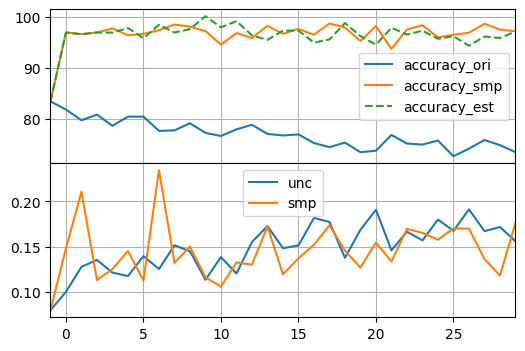

In [10]:
plt.figure(figsize=(6, 4))
gs = GridSpec(nrows=2, ncols=1, hspace=0, wspace=0)
name = "accuracy"
axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].plot(DB["index"], DB[name], label=name+'_ori')
axes[0].plot(DB["index"], DB[name+"_smp"], label=name+"_smp")
axes[0].plot(DB["index"], DB[name+"_est"], label=name+"_est", linestyle="--")

axes[1].plot(DB["index"], DB["uncertainty"], label="unc")
axes[1].plot(DB["index"], DB["uncertainty_smp"], label="smp")

for ax in axes:
    ax.set_xlim(min(DB["index"]), max(DB["index"]))
    ax.grid()
    ax.legend(loc='best')
plt.show()

# 실험

In [13]:
import torch
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [21]:
main_figsize=(15,3)

In [18]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [19]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [16]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis.values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf.values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    return X,Y

## Case #1

In [14]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)

seed_everything(100)

for i in range(400):
    s = i*100
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (2100, 5) X_test, (2100, 5) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)
Search MI & Drift...for X_live_set (94, 2100, 5)


100%|██████████| 94/94 [00:05<00:00, 18.38it/s]


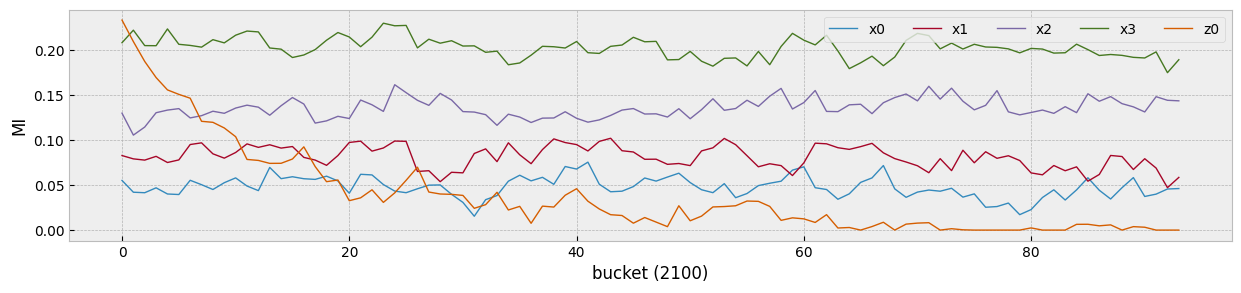

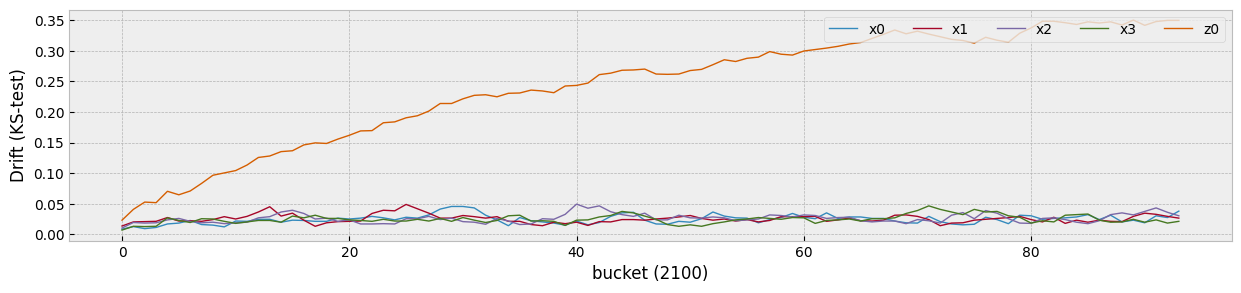

In [22]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 2100
test_size = 400

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)

In [40]:
X1['y'] = y

live_set = []
truncate_count = 0
for i in range(int(X1[2500:].shape[0]/test_size)):
    xl = X1[2500:][i*test_size:i*test_size+train_size]
    if len(xl) ==  2100:
        live_set.append(xl)
    else:
        truncate_count = truncate_count + len(xl)

print(f'Truncate {truncate_count} rows')
print(f'live_set : {np.asarray(live_set).shape}')


Truncate 1500 rows
live_set : (36, 2100, 6)


In [41]:
DB = run(X1[:2100], X1[2100:2500], live_set, columns, ['y'], 'y', 8)

DB setup


100%|██████████| 36/36 [05:40<00:00,  9.47s/it]


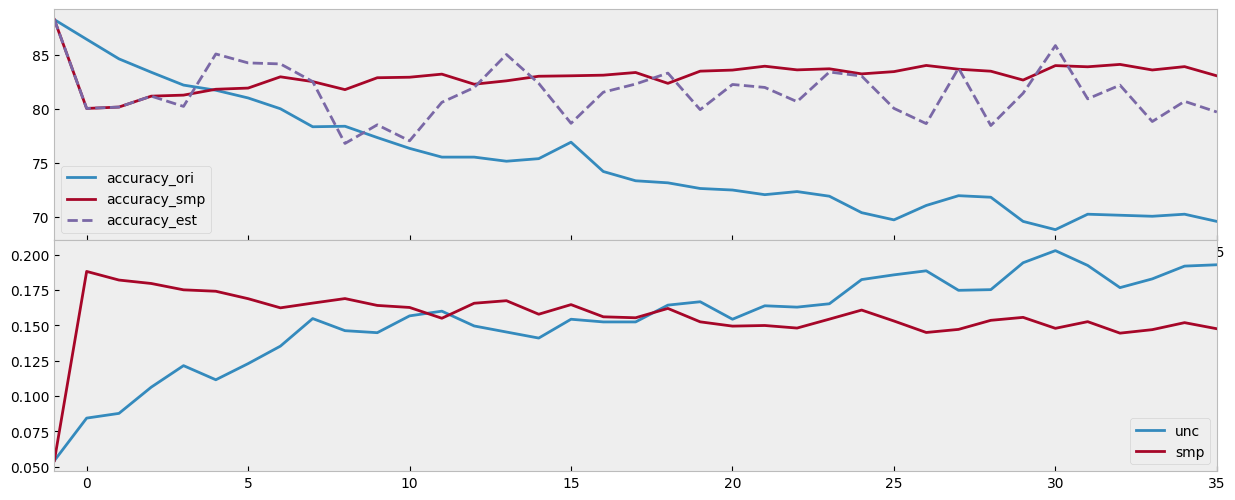

In [42]:
plt.figure(figsize=(15,6))
gs = GridSpec(nrows=2, ncols=1, hspace=0, wspace=0)
name = "accuracy"
axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].plot(DB["index"], DB[name], label=name+'_ori')
axes[0].plot(DB["index"], DB[name+"_smp"], label=name+"_smp")
axes[0].plot(DB["index"], DB[name+"_est"], label=name+"_est", linestyle="--")

axes[1].plot(DB["index"], DB["uncertainty"], label="unc")
axes[1].plot(DB["index"], DB["uncertainty_smp"], label="smp")

for ax in axes:
    ax.set_xlim(min(DB["index"]), max(DB["index"]))
    ax.grid()
    ax.legend(loc='best')
plt.show()

## Case #2

In [44]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

In [45]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21426


MI Analysis MI Max 0.12343, Min 0.00746, Mean 0.05036, Std 0.04482
Dataset structure X_train, (2100, 5) X_test, (2100, 5) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)
Search MI & Drift...for X_live_set (94, 2100, 5)


100%|██████████| 94/94 [00:06<00:00, 15.04it/s]


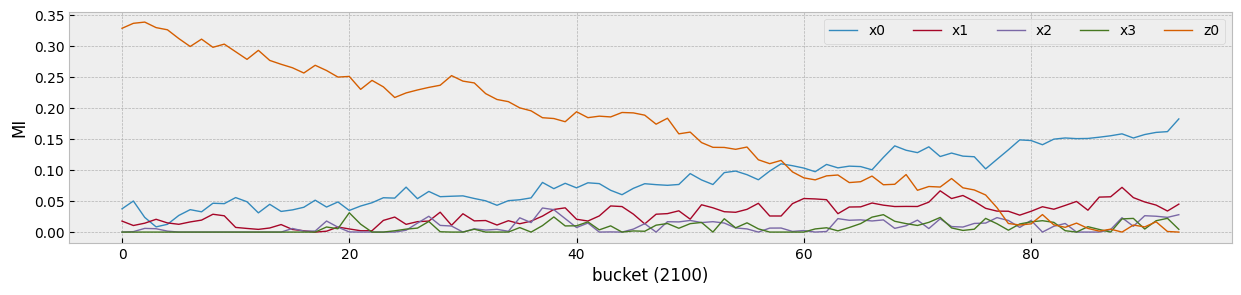

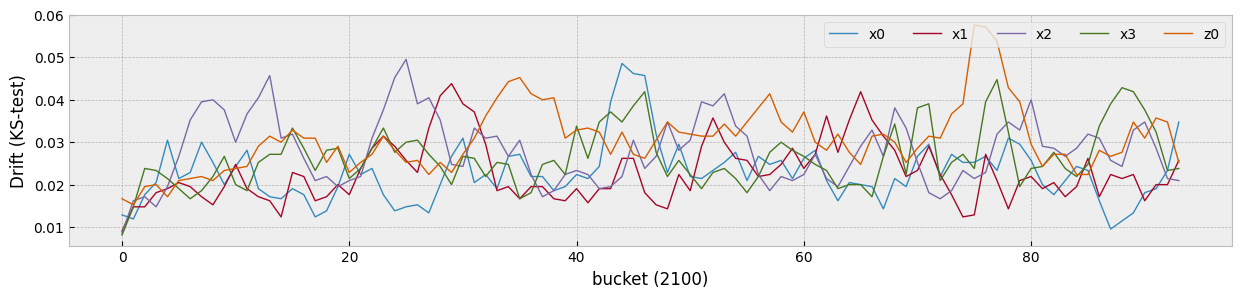

In [47]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 2100
test_size = 400

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)

In [48]:
X1['y'] = y1

live_set = []
truncate_count = 0
for i in range(int(X1[2500:].shape[0]/test_size)):
    xl = X1[2500:][i*test_size:i*test_size+train_size]
    if len(xl) ==  2100:
        live_set.append(xl)
    else:
        truncate_count = truncate_count + len(xl)

print(f'Truncate {truncate_count} rows')
print(f'live_set : {np.asarray(live_set).shape}')

Truncate 5200 rows
live_set : (89, 2100, 6)


In [49]:
DB = run(X1[:2100], X1[2100:2500], live_set, columns, ['y'], 'y', 8)

DB setup


100%|██████████| 89/89 [14:13<00:00,  9.59s/it]


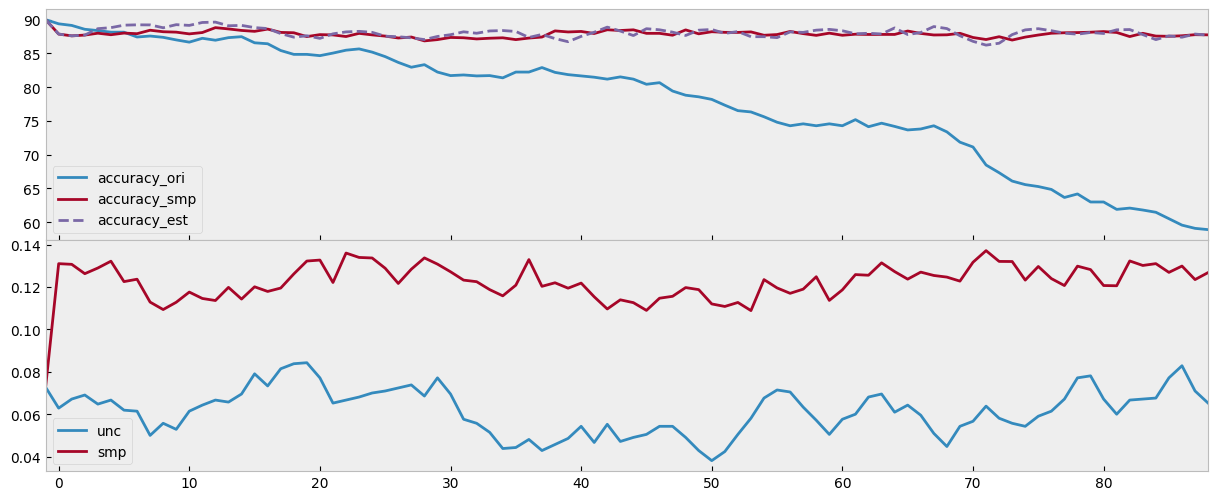

In [50]:
plt.figure(figsize=(15,6))
gs = GridSpec(nrows=2, ncols=1, hspace=0, wspace=0)
name = "accuracy"
axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].plot(DB["index"], DB[name], label=name+'_ori')
axes[0].plot(DB["index"], DB[name+"_smp"], label=name+"_smp")
axes[0].plot(DB["index"], DB[name+"_est"], label=name+"_est", linestyle="--")

axes[1].plot(DB["index"], DB["uncertainty"], label="unc")
axes[1].plot(DB["index"], DB["uncertainty_smp"], label="smp")

for ax in axes:
    ax.set_xlim(min(DB["index"]), max(DB["index"]))
    ax.grid()
    ax.legend(loc='best')
plt.show()

## Case #3

In [51]:
import matplotlib.pyplot as plt

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)


In [52]:
m = 5 #np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

5


26135

MI Analysis MI Max 0.22487, Min 0.00191, Mean 0.07138, Std 0.08241
Dataset structure X_train, (2100, 5) X_test, (2100, 5) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)
Search MI & Drift...for X_live_set (94, 2100, 5)


100%|██████████| 94/94 [00:05<00:00, 16.19it/s]


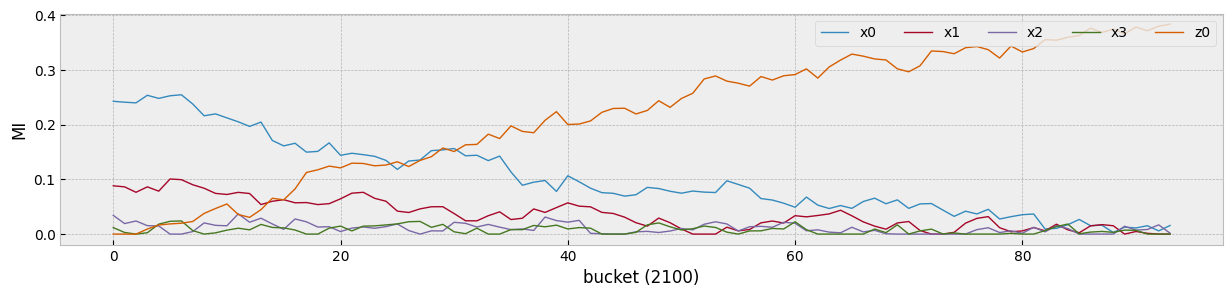

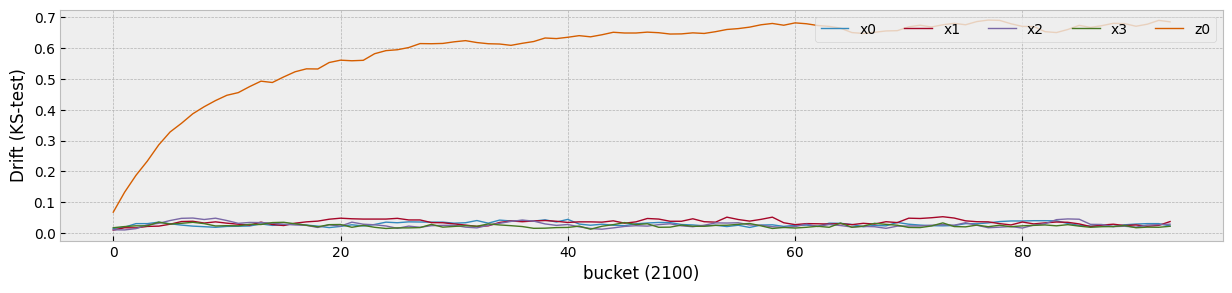

In [53]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x2,columns=columns)

train_size = 2100
test_size = 400

X1,Y1 = check_mi_drift(X1, y2,train_size, test_size)

In [55]:
X1['y'] = Y1

live_set = []
truncate_count = 0
for i in range(int(X1[2500:].shape[0]/test_size)):
    xl = X1[2500:][i*test_size:i*test_size+train_size]
    if len(xl) ==  2100:
        live_set.append(xl)
    else:
        truncate_count = truncate_count + len(xl)

print(f'Truncate {truncate_count} rows')
print(f'live_set : {np.asarray(live_set).shape}')

Truncate 5200 rows
live_set : (89, 2100, 6)


In [56]:
DB = run(X1[:2100], X1[2100:2500], live_set, columns, ['y'], 'y', 8)

DB setup


100%|██████████| 89/89 [14:38<00:00,  9.87s/it]


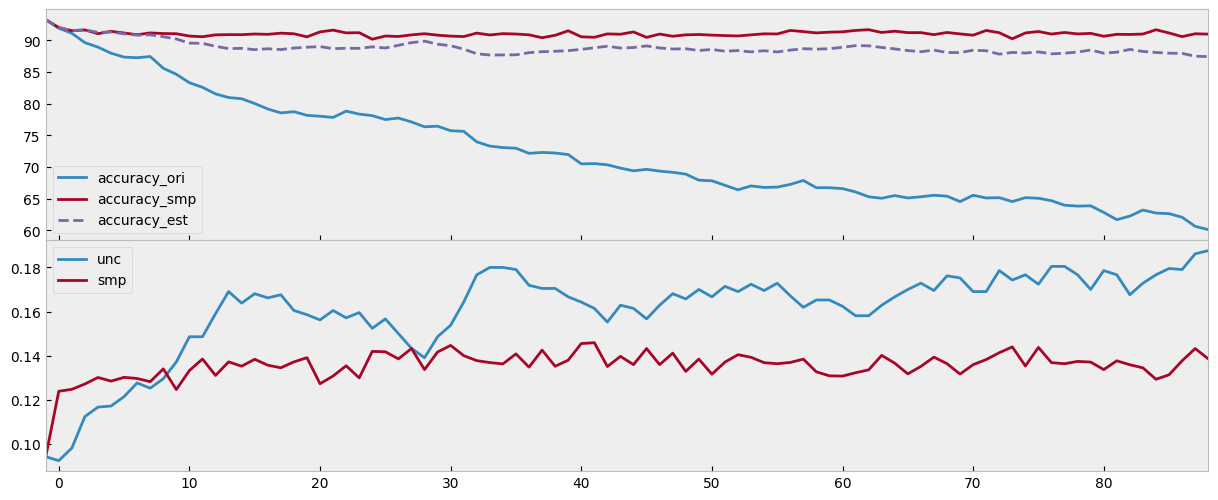

In [57]:
plt.figure(figsize=(15,6))
gs = GridSpec(nrows=2, ncols=1, hspace=0, wspace=0)
name = "accuracy"
axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].plot(DB["index"], DB[name], label=name+'_ori')
axes[0].plot(DB["index"], DB[name+"_smp"], label=name+"_smp")
axes[0].plot(DB["index"], DB[name+"_est"], label=name+"_est", linestyle="--")

axes[1].plot(DB["index"], DB["uncertainty"], label="unc")
axes[1].plot(DB["index"], DB["uncertainty_smp"], label="smp")

for ax in axes:
    ax.set_xlim(min(DB["index"]), max(DB["index"]))
    ax.grid()
    ax.legend(loc='best')
plt.show()

## Case #4

In [58]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (2100, 5) X_test, (2100, 5) X_live (39600, 5)
Truncate 6000 rows from live_set (39600, 5)
Search MI & Drift...for X_live_set (94, 2100, 5)


100%|██████████| 94/94 [00:07<00:00, 12.15it/s]


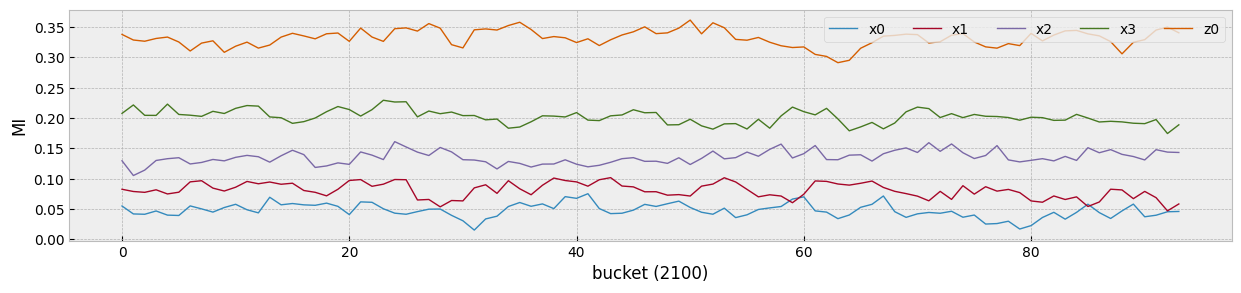

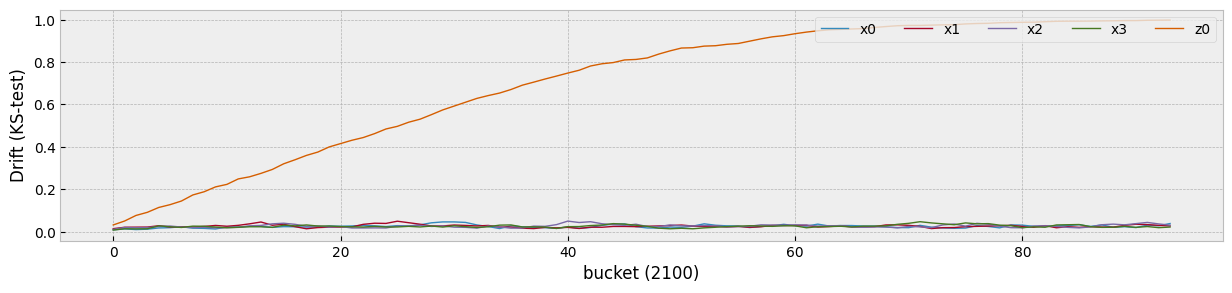

In [59]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x3,columns=columns)

train_size = 2100
test_size = 400

X1,Y1 = check_mi_drift(X1, y3,train_size, test_size)

In [60]:
X1['y'] = Y1

live_set = []
truncate_count = 0
for i in range(int(X1[2500:].shape[0]/test_size)):
    xl = X1[2500:][i*test_size:i*test_size+train_size]
    if len(xl) ==  2100:
        live_set.append(xl)
    else:
        truncate_count = truncate_count + len(xl)

print(f'Truncate {truncate_count} rows')
print(f'live_set : {np.asarray(live_set).shape}')

Truncate 5200 rows
live_set : (89, 2100, 6)


In [61]:
DB = run(X1[:2100], X1[2100:2500], live_set, columns, ['y'], 'y', 8)

DB setup


100%|██████████| 89/89 [14:39<00:00,  9.88s/it]


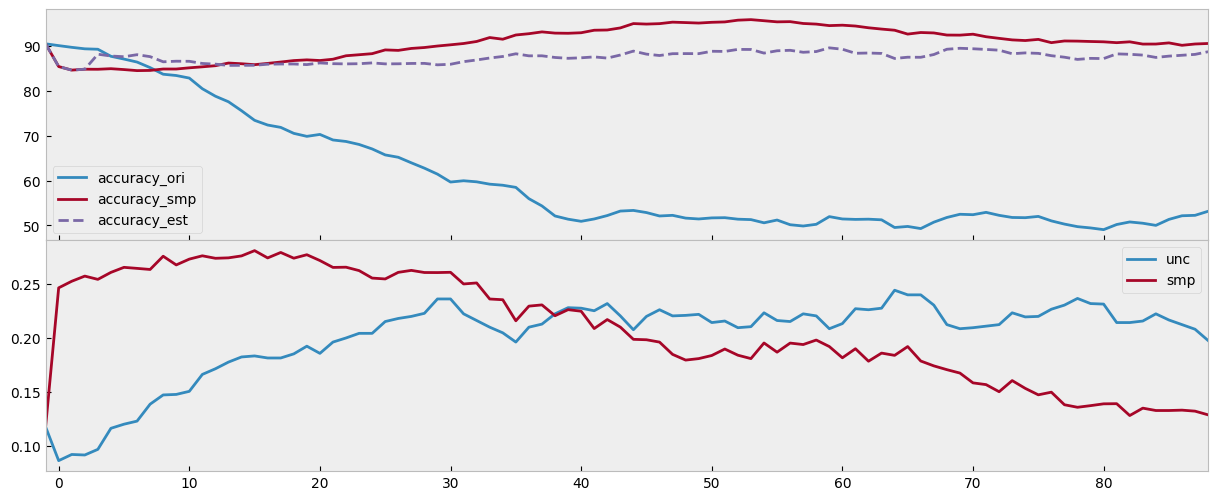

In [62]:
plt.figure(figsize=(15,6))
gs = GridSpec(nrows=2, ncols=1, hspace=0, wspace=0)
name = "accuracy"
axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].plot(DB["index"], DB[name], label=name+'_ori')
axes[0].plot(DB["index"], DB[name+"_smp"], label=name+"_smp")
axes[0].plot(DB["index"], DB[name+"_est"], label=name+"_est", linestyle="--")

axes[1].plot(DB["index"], DB["uncertainty"], label="unc")
axes[1].plot(DB["index"], DB["uncertainty_smp"], label="smp")

for ax in axes:
    ax.set_xlim(min(DB["index"]), max(DB["index"]))
    ax.grid()
    ax.legend(loc='best')
plt.show()